# Maaslin2 functions

## General variables and libraries
Run this cell first

In [1]:
import os
import numpy as np
import pandas as pd
from itertools import combinations

#VARIABLES
TABS = 'Data/FTables/'
META = pd.read_csv('metadata.tsv', sep='\t', index_col=0)
MAASLIN2 = '~/Nextcloud*/Tools/Maaslin2-master/R' #path to maaslin2 folder for CLI

LEVS = {
    'PWY': 3}

STYPES = {
    'RSP': 'RSP', 
    'RF': 'RF', 
    'FL': 'Fermenter liquid', 
    'FR': 'Feed residue'}

CDICT = {
    'TMR': 'grey',
    'AN1': 'limegreen',
    'AN2': 'green',
    'AT': 'red',
    'FV1': 'deepskyblue',
    'FV2': 'blue',
    'NoT': 'whitesmoke'}

KO_TABS = {
    'KO': 'Metabolism',
    'KO_methane': 'Methane metabolism',}
    #'PWY': 'Pathways'}

In [80]:
# collapse tables for Maaslin2
for lev in LEVS:
    TABLE = f'{TABS}/KO_table.qza'
    colap = f'{TABS}/KO_table_{lev}.qza'
    ttsv = f'{TABS}/{lev}_table.tsv'
    l = LEVS[lev]

    !qiime taxa collapse \
        --i-table $TABLE \
        --i-taxonomy Data/KO-taxonomy.qza \
        --p-level 3 \
        --o-collapsed-table $colap
    
    !qiime tools export \
        --input-path $colap \
        --output-path $TABS
    
    !biom convert -i $TABS/feature-table.biom -o $ttsv --to-tsv
    
    !rm -rf $TABS/feature-table.biom
    
    df = pd.read_csv(ttsv, sep='\t', index_col=0, skiprows=1)
    df.index = df.index.str.split(';').str[-1]
    df = df.groupby(level=0, axis=0).sum()
    df.to_csv(ttsv, sep='\t')

Saved FeatureTable[Frequency] to: Data/FTables//KO_table_PWY.qza
Exported Data/FTables//KO_table_PWY.qza as BIOMV210DirFmt to directory Data/FTables/


# Maaslin2 by sample types

### Run in maaslin2 env

In [2]:
!chmod -R 755 ~/Nextcloud*/Tools/Maaslin2-master

In [2]:
#by phases
random = "rstc_run"
fixed = "Trt"
refer = "Trt,TMR"

for ko in KO_TABS:
    a = 10
    #if ko != 'PWY':
    #    continue
    #a = 1000
    
    data = pd.read_csv(f'{TABS}/{ko}_table.tsv', sep='\t', index_col=0)
    for st in STYPES:
        if st in ['RSP', 'RF']:
            continue
        maaslin = f'Results/Maaslin2/{ko}/{st}'

        !mkdir -p $maaslin

        meta = META.loc[(META.BS == st)].copy()
        feat = data[meta.index].copy()
        feat.to_csv(f'{maaslin}/features.tsv', sep='\t')
        meta.to_csv(f'{maaslin}/metadata.tsv', sep='\t')

        #Maaslin2
        run = !$MAASLIN2/Maaslin2.R --fixed=$fixed --random=$random --standardize=False \
        $maaslin/features.tsv $maaslin/metadata.tsv $maaslin --reference=$refer -a $a -p 0.02 -o False
        
        if 'significant_results.tsv' not in ''.join(run):
            print(maaslin, 'Error')
            print(run)
        else:
            print(maaslin, 'Done')

Results/Maaslin2/PWY/FL Done
Results/Maaslin2/PWY/FR Done


In [5]:
!$MAASLIN2/Maaslin2.R --help

Usage: /home/ty/Nextcloud/Tools/Maaslin2-master/R/Maaslin2.R [options]  <data.tsv>  <metadata.tsv>  <output_folder>


Options:
	-h, --help
		Show this help message and exit

	-a MIN_ABUNDANCE, --min_abundance=MIN_ABUNDANCE
		The minimum abundance for each feature[ Default: 0 ]

	-p MIN_PREVALENCE, --min_prevalence=MIN_PREVALENCE
		The minimum percent of samples for whicha feature is detected at minimum abundance[ Default: 0.1 ]

	-b MIN_VARIANCE, --min_variance=MIN_VARIANCE
		Keep features with variancesgreater than value[ Default: 0 ]

	-s MAX_SIGNIFICANCE, --max_significance=MAX_SIGNIFICANCE
		The q-value threshold for significance[ Default: 0.25 ]

	-n NORMALIZATION, --normalization=NORMALIZATION
		The normalization method to apply [ Default: TSS ] [ Choices: TSS, CLR, CSS, NONE, TMM ]

	-t TRANSFORM, --transform=TRANSFORM
		The transform to apply [ Default: LOG ] [ Choices: LOG, LOGIT, AST, NONE ]

	-m ANALYSIS_METHOD, --analysis_method=ANALYSIS_METHOD
		The analysis method to appl

### Summarize Maaslin2 runs

In [2]:
for ko in KO_TABS:
    maaslin = f'Results/Maaslin2/{ko}/'
    summ = pd.DataFrame()
    for out in os.listdir(maaslin):
        if out.endswith('.tsv') or out.startswith('.'): 
            continue
        res = pd.read_csv(f'{maaslin}/{out}/significant_results.tsv', sep='\t', index_col=0)
        if len(res) == 0: 
            continue  #skip if no results
        res['sType'] = out
        summ = pd.concat([summ, res], ignore_index=False)
    if len(summ) == 0: continue  #skip if no results
    display(summ)
    summ.to_csv(f'Results/Maaslin2/Maaslin2_summ_{ko}.tsv', sep='\t')

,metadata,value,coef,stderr,N,N.not.0,pval,qval,sType
feature,,,,,,,,,
K04037,Trt,FV1,7.214107,0.431094,24,18,2.038892e-12,1.789961e-08,FR
K00202,Trt,AT,-7.121881,0.429360,24,21,2.368457e-12,1.789961e-08,FR
K13812,Trt,AT,-5.207724,0.334934,24,21,1.748777e-11,7.327746e-08,FR
K04037,Trt,FV2,6.310235,0.431094,24,18,1.939198e-11,7.327746e-08,FR
K05289,Trt,FV1,10.091125,0.701388,24,20,5.989307e-11,1.810567e-07,FR
...,...,...,...,...,...,...,...,...,...
K01697,Trt,AT,0.655036,0.272959,24,24,2.744071e-02,2.496798e-01,FL
K00374,Trt,AN1,0.591938,0.245418,24,24,2.745365e-02,2.496798e-01,FL
K05342,Trt,AN1,0.528141,0.219010,24,24,2.748000e-02,2.496798e-01,FL


,metadata,value,coef,stderr,N,N.not.0,pval,qval,sType
feature,,,,,,,,,
K00202,Trt,AT,-7.001122,0.424352,24,21,2.594070e-12,1.141391e-09,FR
K13812,Trt,AT,-5.086965,0.326775,24,21,1.715633e-11,3.774392e-09,FR
K07144,Trt,AT,-6.388652,0.538887,24,21,6.133589e-10,8.737467e-08,FR
K11260,Trt,AT,-5.510492,0.472371,24,22,7.943152e-10,8.737467e-08,FR
K07072,Trt,AT,-5.106242,0.425861,24,23,1.018636e-09,8.963994e-08,FR
...,...,...,...,...,...,...,...,...,...
K16179,Trt,AT,-1.069288,0.468312,24,24,3.478404e-02,1.956602e-01,FL
K14067,Trt,AN1,-2.232665,0.999830,24,15,3.927955e-02,2.155585e-01,FL
K00625,Trt,AT,0.277439,0.124659,24,24,3.906118e-02,2.155585e-01,FL


,metadata,value,coef,stderr,N,N.not.0,pval,qval,sType
feature,,,,,,,,,
C5.Branched.dibasic.acid.metabolism,Trt,AT,0.596515,0.101989,24,24,0.000019,0.005803,FL
Citrate.cycle..TCA.cycle.,Trt,AT,0.139421,0.022689,24,24,0.000011,0.005803,FL
Galactose.metabolism,Trt,AT,0.284719,0.050701,24,24,0.000031,0.006175,FL
Folate.biosynthesis,Trt,AT,-0.207051,0.040739,24,24,0.000092,0.009349,FL
Nitrogen.metabolism,Trt,FV1,0.099503,0.019335,24,24,0.000081,0.009349,FL
Nitrogen.metabolism,Trt,FV2,0.096931,0.019335,24,24,0.000107,0.009349,FL
Pentose.and.glucuronate.interconversions,Trt,AT,0.351113,0.070192,24,24,0.000109,0.009349,FL
Alanine..aspartate.and.glutamate.metabolism,Trt,AT,0.163670,0.033667,24,24,0.000147,0.009716,FL
Glycolysis...Gluconeogenesis,Trt,AT,-0.098974,0.020559,24,24,0.000162,0.009716,FL


## Plot figures
Run in qiime2 env.

In [2]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import matplotlib.ticker as mticker
#from statannot import add_stat_annotation
#import colorcet as cc
import matplotlib.patches as mpatches

%matplotlib inline

sns.set_style("ticks")
plt.rcParams['axes.linewidth'] = .8 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure

!mkdir -p Figures/Maaslin2

### Percentage of Maaslin2 DAFs

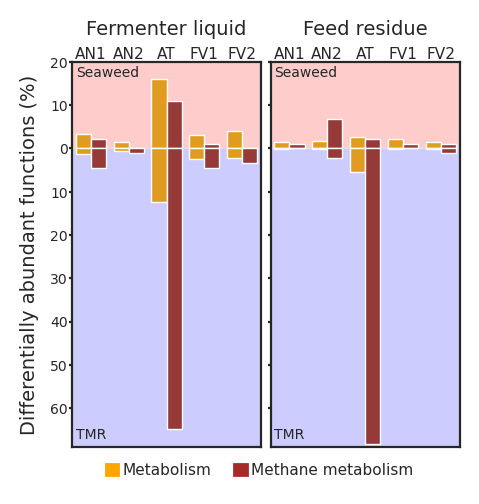

In [6]:
#function to remove "-" from y ticks
def update_ticks(t, pos):
    return str(t).strip('-').split('.')[0]


sign_count = pd.DataFrame() #dataframe to store DAF percentages

cdict = {
    'Metabolism': 'orange',
    'Methane metabolism': 'brown',}
    #'Pathways': 'green'}

#set figure
fig, axes = plt.subplots(1, 2, figsize=(2.5, 2.5), sharey='row', gridspec_kw={'wspace': 0.05})

for i, st in enumerate([s for s in STYPES if s not in ['RSP', 'RF']]):
    
    #get percentage of DAF by treatments 
    for ko in KO_TABS:
        summ = pd.read_csv(f'Results/Maaslin2/Maaslin2_summ_{ko}.tsv', sep='\t', index_col=0)
        
        #get table with all functions by stypes
        meta = META.loc[(META.BS==st)].copy()
        data = pd.read_csv(f'{TABS}/{ko}_table.tsv', sep='\t', index_col=0) #all functions
        data = data[meta.index].copy()
        data = data.loc[~(data==0).all(axis=1)]

        for trt in CDICT:
            if trt in ['TMR', 'NoT']:
                continue
            j = len(sign_count)
            sign = summ.loc[(summ.sType==st) & (summ.value==trt)].copy()
            pos = sign.loc[~sign.coef.astype(str).str.startswith('-')]
            neg = sign.loc[sign.coef.astype(str).str.startswith('-')]
            sign_count.loc[j, 'sType'] = st
            sign_count.loc[j, 'Function'] = KO_TABS[ko]
            sign_count.loc[j, 'Trt'] = trt
            sign_count.loc[j, 'All_functions'] = len(data.index.unique())
            sign_count.loc[j, 'Sig_functions'] = len(sign.index.unique())
            sign_count.loc[j, 'Sig_%'] = (len(sign.index.unique())/len(data.index.unique()))*100
            sign_count.loc[j, 'Pos_functions'] = len(pos.index.unique())
            sign_count.loc[j, 'Pos_%'] = (len(pos.index.unique())/len(data.index.unique()))*100
            sign_count.loc[j, 'Neg_functions'] = len(neg.index.unique())
            sign_count.loc[j, 'Neg_%'] = (len(neg.index.unique())/len(data.index.unique()))*-100
            
    #plot data
    ax = axes[i]
    df = sign_count.loc[sign_count.sType==st].copy()
    sns.barplot(data=df, ax=ax, x="Trt", y="Pos_%", hue="Function", palette=cdict, )
    sns.barplot(data=df, ax=ax, x="Trt", y="Neg_%", hue="Function", palette=cdict)
            
    #set background color
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax)
    ax.axhspan(0, ymax, facecolor='red', alpha=0.2, zorder=0)
    ax.axhspan(0, ymin, facecolor='blue', alpha=0.2, zorder=0)
    
    #aesthetics
    ax.tick_params(axis='both', labelsize=5, length=1, pad=.5,)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.text(0.5, 1.07, STYPES[st], ha='center', fontsize=7, transform=ax.transAxes)
    if i == 0: 
        ax.set_ylabel('Differentially abundant functions (%)', fontsize=7)
    plt.setp(ax.patches, linewidth=0.5) #decrease lines around charts
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks)) #remove "-" from y ticks
    ax.text(.02, .96,'Seaweed', size=5, transform=ax.transAxes, ha='left') #annotated upper half
    ax.text(.02, .02,'TMR', size=5, transform=ax.transAxes, ha='left') #annotated lower half
    
    #annotate sides
    xlabels = [item.get_text() for item in ax.get_xticklabels()]
    for pos, lab in enumerate(xlabels):
        xstep = 1/len(xlabels)
        xpos = pos*xstep + xstep/2
        ax.text(xpos, 1.04, lab, size=5.5, ha='center', va='top', transform=ax.transAxes)
    ax.set_xticks([])
    
    #legend
    ax.get_legend().remove()

#legend
labels = list(cdict.keys())
handles = [mpatches.Patch(color=cdict[l], label=l) for l in labels]

fig.legend(handles, labels, fontsize=5.5, frameon=False, handletextpad=.3, handlelength=.8,
          loc=8, ncol=3, bbox_to_anchor=(0.5, .02), columnspacing=1.5)

sign_count.to_csv('Results/Maaslin2/Maaslin2_DAF_percentage.tsv', sep='\t')     
plt.savefig('Figures/Maaslin2/Maaslin2_DAF_percentage.png', bbox_inches='tight', facecolor="w")

### Ko pathways

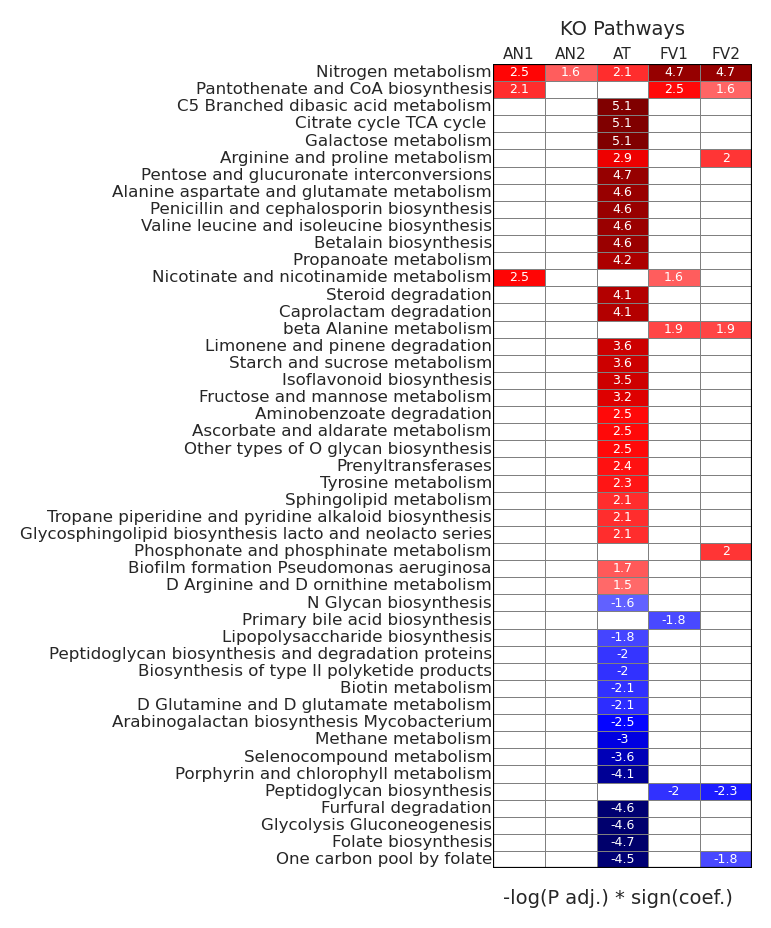

In [5]:
drep = {
    '_': ' ',
    '.': ' ',
    '   ': ' ',
    '  ': ' ',}

scale = 9
sorter = list(CDICT.keys())[1:-1]

#learn lengths and cbar max and min values
summ = pd.read_csv(f'Results/Maaslin2/Maaslin2_summ_PWY.tsv', sep='\t', index_col=0)
summ['hm_value'] = -np.log(summ.qval)*np.sign(summ.coef) #calculate sign. coefficient   
length = len(summ.index.unique())
vmax = summ.hm_value.max()
vmin = summ.hm_value.min()
summ['ID'] = summ.index.str.strip('_')
for k, v in drep.items():
    summ['ID'] = summ.ID.map(lambda x: x.replace(k, v))
    
#declare figure
fig, ax = plt.subplots(1, 1, figsize=(len(sorter)/3, length/scale))


hdf = summ.pivot(index='ID', columns='value', values='hm_value')
for col in sorter:
    if col not in hdf.columns:
        hdf[col] = np.nan
hdf = hdf[sorter]

#sort rows
hdf['sum'] = hdf.sum(1)
hdf = hdf.sort_values(by='sum', ascending=False, axis=0)
hdf.drop(['sum'], axis=1, inplace = True)

#plot
sns.heatmap(data=hdf, ax=ax, cbar_kws={'orientation': 'horizontal'}, annot=True, cbar=False, 
            square=False, center=0, cmap='seismic', xticklabels=True, yticklabels=True,
            annot_kws={"size":4.5}, linewidths=.3, linecolor='grey', vmax=vmax, vmin=vmin)

#aestheticks
ax.text(len(sorter)/2, -1.7, 'KO Pathways', ha='center', fontsize=7, transform=ax.transData)
ax.tick_params(rotation=0, axis='both', labelsize=6, length=0, pad=.5)
ax.tick_params(axis='x', labelsize=7,)
ax.set_xlabel('')
ax.set_ylabel('')

#set lines around heatmap
ax.axhline(y=0, color='k',linewidth=.8)
ax.axhline(y=len(hdf), color='k',linewidth=.8)
ax.axvline(x=0, color='k',linewidth=.8)
ax.axvline(x=len(sorter), color='k',linewidth=.8)

#annotate sides
xlabels = [item.get_text() for item in ax.get_xticklabels()]
for pos, lab in enumerate(xlabels):
    ax.text(pos+.5, -1, lab, size=5.5, ha='center', va='top', transform=ax.transData)
ax.set_xticks([])
    
fig.suptitle('-log(P adj.) * sign(coef.)', fontsize=7, y=.09)
plt.savefig('Figures/Maaslin2/KO_Pathways.png', bbox_inches='tight', facecolor='w')

### KO Methane metabolism

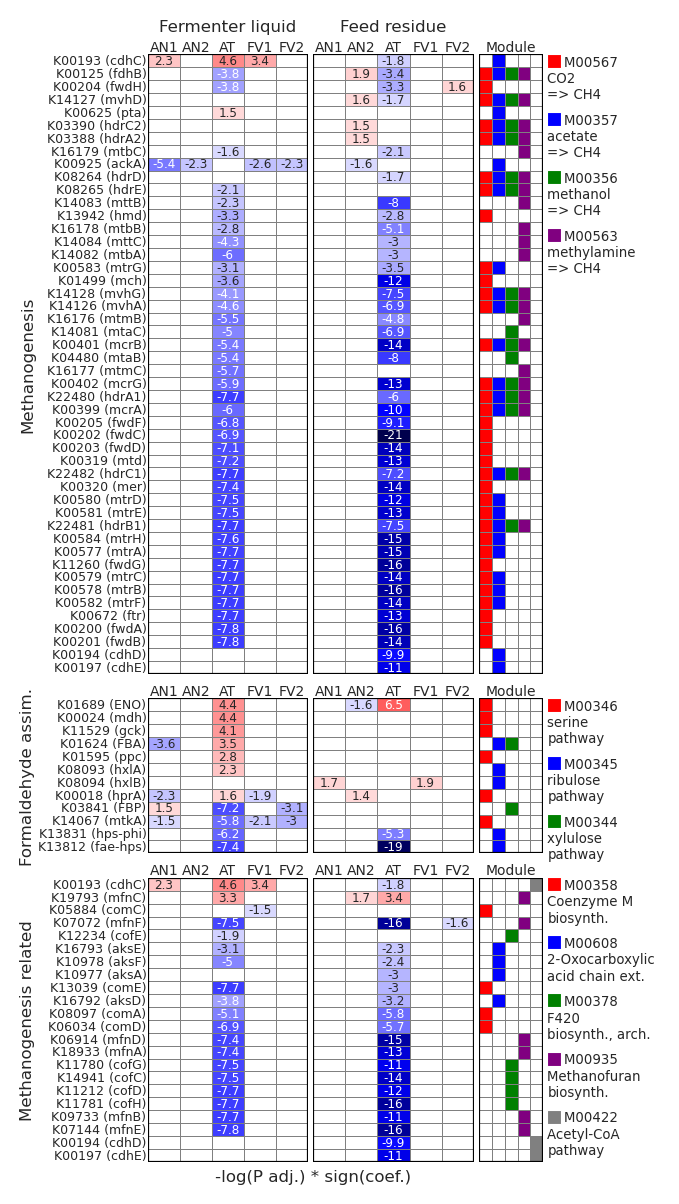

In [8]:
from matplotlib.colors import ListedColormap


def aesthetics(ax, ylen, xlen):
    ax.axhline(y=0, color='k',linewidth=.8)
    ax.axhline(y=ylen, color='k',linewidth=.8)
    ax.axvline(x=0, color='k',linewidth=.8)
    ax.axvline(x=xlen, color='k',linewidth=.8)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(rotation=0, axis='both', labelsize=4.5, length=0, pad=.5)
    

drep = {
    '=>': '\n=>',
    'methane': 'CH4',
    'pathway': '\npathway',
    'acid chain extension': '\nacid chain ext.',
    ': ': '\n',
    'di/tri/': '',
    'biosynthesis': '\nbiosynth.',
    'monophosphate': '',
    'archaea': 'arch.'}
    
MModTabs = 'Data/Methane_modules'
colors = ['Red', 'Blue', 'Green', 'Purple', 'Grey']
cmap = ListedColormap(colors)

MM = pd.read_csv(f'{MModTabs}/Methane_metabolism_KOs.tsv', sep='\t', index_col=0)
#MM = MM.drop_duplicates(keep=False)
MM['KO_Gene'] = MM.KO +' ('+ MM.Gene + ')'
summ = pd.read_csv(f'Results/Maaslin2/Maaslin2_summ_KO_methane.tsv', sep='\t', index_col=0)
MM = MM.loc[MM.KO.isin(summ.index)]
summ['KO_Gene'] = summ.index
for ind in MM.index:
    summ.loc[summ.KO_Gene == MM.loc[ind, 'KO'], 'KO_Gene'] = MM.loc[ind, 'KO_Gene']
summ['hm_value'] = -np.log(summ.qval)*np.sign(summ.coef) #calculate sign. coefficient 
summ = summ.sort_values(by='hm_value', ascending=False, axis=0)
vmax = summ.hm_value.max()
vmin = summ.hm_value.min()

scale = 12
L = len(summ.index.unique())/scale
cats = MM.Category.unique()
sorter = list(CDICT.keys())[1:-1]

#learn lengths of subplots by cats, order of functions and numbers of modules by cat
lengths, iorder, modules = [], [], []
for cat in cats:
    mm = MM.loc[MM.Category==cat].copy()
    lengths.append(len(mm.KO.unique()))
    df = summ.loc[(summ.index.isin(mm.KO))]
    iorder.append(df.KO_Gene.unique())
    modules.append(mm.Module.unique().tolist())
modcolsmax = max([len(m) for m in modules])

#set figure
fig, axes = plt.subplots(len(cats), 4, figsize=(3, L + 2*(len(cats[:-1])/L)), 
                sharey='row', gridspec_kw={'width_ratios': [5, 5, 2, 2], 'height_ratios': lengths, 
                'wspace': .05, 'hspace': .5/(L + 2*(len(cats[:-1])/L))},)
axs, i = [[r, c] for r in range(len(cats)) for c in range(4)], 0
    
for j, cat in enumerate(MM.Category.unique()):
    mm = MM.loc[MM.Category == cat].copy()
    for st in [s for s in STYPES if s not in ['RSP', 'RF']]:
        df = summ.loc[(summ.index.isin(mm.KO)) & (summ.sType == st)].copy()
        hdf = df.pivot(index='KO_Gene', columns='value', values='hm_value')
        
        #sort columns
        for col in sorter:
            if col not in hdf.columns:
                hdf[col] = np.nan
        hdf = hdf[sorter]
    
        #sort rows
        for ind in iorder[j]:
            if ind not in hdf.index:
                hdf.loc[ind, :] = np.nan
        hdf = hdf.reindex(iorder[j])

        #plot
        ax, i = axes[axs[i][0]][axs[i][1]], i+1
        sns.heatmap(data=hdf, ax=ax, annot=True, cbar=False, 
                    square=False, center=0, cmap='seismic', xticklabels=True, yticklabels=True,
                    annot_kws={"size":4.3}, linewidths=.3, linecolor='grey', vmax=vmax, vmin=vmin)
        
        #annotate sides
        xlabels = [item.get_text() for item in ax.get_xticklabels()]
        for pos, lab in enumerate(xlabels):
            ax.text(pos+.5, -1.1, lab, size=5, ha='center', va='top', transform=ax.transData)
            
        #aestheticks
        aesthetics(ax, len(hdf), len(sorter))
        if cat == cats[0]:
            ax.text(len(sorter)/2, -1.8, STYPES[st], ha='center', fontsize=6, 
                    transform=ax.transData)
        if st == 'FL':
            ax.set_ylabel(cat.replace('ilation', '.'), fontsize=6, labelpad=1)
        
        #add reactions/modules
        if st == 'FR':
            hmd = pd.DataFrame()
            for ind in iorder[j]:
                for ci, c in enumerate(modules[j]):
                    if len(mm.loc[(mm.KO_Gene==ind) & (mm.Module==c)]) > 0:
                        hmd.loc[ind, ci] = ci
                    else:
                        hmd.loc[ind, ci] = np.nan
            #sort columns
            for col in list(range(modcolsmax)):
                if col not in hmd.columns:
                    hmd[col] = np.nan
            hmd = hmd[list(range(modcolsmax))]
            #print(modules[j])
            #display(hmd)
            ax, i = axes[axs[i][0]][axs[i][1]], i+1
            sns.heatmap(data=hmd, cmap=cmap, ax=ax, cbar=False, linewidths=.3, linecolor='grey', 
                        xticklabels=True, yticklabels=True, vmax=modcolsmax, vmin=0)
            #aestheticks
            aesthetics(ax, len(hmd), modcolsmax)
            ax.text(modcolsmax/2, -1.1, 'Module', ha='center', va='top', fontsize=5, transform=ax.transData)
                
            #add reactions legend
            ax, i = axes[axs[i][0]][axs[i][1]], i+1
            ax.axis('off')
            ax.set_xlim(0, 1)
            yax, xax = .5, .08
            ystep, xstep = 4.5, .1
            fsize = 4.8
            
            for ri, r in enumerate(modules[j]): #colors             
                sns.scatterplot(x=[xax], y=[yax], marker='s', color=colors[ri], ax=ax, s=25, 
                                clip_on=False, ec='white')
                for k, v in drep.items():
                    r = r.replace(k, v)
                ax.text(xax-xstep, yax+2.9, f"    {r}", fontdict={'size': fsize})
                yax += ystep
        
fig.align_labels()
fig.suptitle('-log(P adj.) * sign(coef.)', fontsize=6, y=.105, x=.4)
plt.savefig('Figures/Maaslin2/KO_Methanogenesis.png', bbox_inches='tight', facecolor='w')

# Maaslin2 with sample types pooled

### Run in maaslin2 env

In [2]:
!chmod -R 755 ~/Nextcloud*/Tools/Maaslin2-master

In [2]:
#by phases
random = "rstc_run,BS"
fixed = "Trt"
refer = "Trt,TMR"

for ko in KO_TABS:
    a = 10
    #if ko != 'PWY':
    #    continue
    #a = 1000
    
    data = pd.read_csv(f'{TABS}/{ko}_table.tsv', sep='\t', index_col=0)

    maaslin = f'Results/Maaslin2-pooled/{ko}'

    !mkdir -p $maaslin

    meta = META.loc[(META.BS.isin(['FL', 'FR']))].copy()
    feat = data[meta.index].copy()
    #feat = np.log(feat, where=feat>0)
    feat.to_csv(f'{maaslin}/features.tsv', sep='\t')
    meta.to_csv(f'{maaslin}/metadata.tsv', sep='\t')

    #Maaslin2
    run = !$MAASLIN2/Maaslin2.R --fixed=$fixed --random=$random --reference=$refer \
    $maaslin/features.tsv $maaslin/metadata.tsv $maaslin -a $a -p 0.02 -o False

    if 'significant_results.tsv' not in ''.join(run):
        print(maaslin, 'Error')
        print(run)
    else:
        print(maaslin, 'Done')

Results/Maaslin2-pooled/KO Done
Results/Maaslin2-pooled/KO_methane Done


In [5]:
!$MAASLIN2/Maaslin2.R --help

Usage: /home/ty/Nextcloud/Tools/Maaslin2-master/R/Maaslin2.R [options]  <data.tsv>  <metadata.tsv>  <output_folder>


Options:
	-h, --help
		Show this help message and exit

	-a MIN_ABUNDANCE, --min_abundance=MIN_ABUNDANCE
		The minimum abundance for each feature[ Default: 0 ]

	-p MIN_PREVALENCE, --min_prevalence=MIN_PREVALENCE
		The minimum percent of samples for whicha feature is detected at minimum abundance[ Default: 0.1 ]

	-b MIN_VARIANCE, --min_variance=MIN_VARIANCE
		Keep features with variancesgreater than value[ Default: 0 ]

	-s MAX_SIGNIFICANCE, --max_significance=MAX_SIGNIFICANCE
		The q-value threshold for significance[ Default: 0.25 ]

	-n NORMALIZATION, --normalization=NORMALIZATION
		The normalization method to apply [ Default: TSS ] [ Choices: TSS, CLR, CSS, NONE, TMM ]

	-t TRANSFORM, --transform=TRANSFORM
		The transform to apply [ Default: LOG ] [ Choices: LOG, LOGIT, AST, NONE ]

	-m ANALYSIS_METHOD, --analysis_method=ANALYSIS_METHOD
		The analysis method to appl

In [2]:
for ko in KO_TABS:
    maaslin = f'Results/Maaslin2-pooled/{ko}'
    summ = pd.DataFrame()
    for out in os.listdir(maaslin):
        if out.endswith('.tsv') or out.startswith('.'): 
            continue
        res = pd.read_csv(f'{maaslin}/{out}/significant_results.tsv', sep='\t', index_col=0)
        if len(res) == 0: 
            continue  #skip if no results
        res['sType'] = out
        summ = pd.concat([summ, res], ignore_index=False)
    if len(summ) == 0: continue  #skip if no results
    display(summ)
    summ.to_csv(f'Results/Maaslin2-pooled/Maaslin2_summ_{ko}.tsv', sep='\t')

,metadata,value,coef,stderr,N,N.not.0,pval,qval,sType
feature,,,,,,,,,
K04037,Trt,FV1,7.214107,0.431094,24,18,2.038892e-12,1.789961e-08,FR
K00202,Trt,AT,-7.121881,0.429360,24,21,2.368457e-12,1.789961e-08,FR
K13812,Trt,AT,-5.207724,0.334934,24,21,1.748777e-11,7.327746e-08,FR
K04037,Trt,FV2,6.310235,0.431094,24,18,1.939198e-11,7.327746e-08,FR
K05289,Trt,FV1,10.091125,0.701388,24,20,5.989307e-11,1.810567e-07,FR
...,...,...,...,...,...,...,...,...,...
K01697,Trt,AT,0.655036,0.272959,24,24,2.744071e-02,2.496798e-01,FL
K00374,Trt,AN1,0.591938,0.245418,24,24,2.745365e-02,2.496798e-01,FL
K05342,Trt,AN1,0.528141,0.219010,24,24,2.748000e-02,2.496798e-01,FL


,metadata,value,coef,stderr,N,N.not.0,pval,qval,sType
feature,,,,,,,,,
K00202,Trt,AT,-7.001122,0.424352,24,21,2.594070e-12,1.141391e-09,FR
K13812,Trt,AT,-5.086965,0.326775,24,21,1.715633e-11,3.774392e-09,FR
K07144,Trt,AT,-6.388652,0.538887,24,21,6.133589e-10,8.737467e-08,FR
K11260,Trt,AT,-5.510492,0.472371,24,22,7.943152e-10,8.737467e-08,FR
K07072,Trt,AT,-5.106242,0.425861,24,23,1.018636e-09,8.963994e-08,FR
...,...,...,...,...,...,...,...,...,...
K16179,Trt,AT,-1.069288,0.468312,24,24,3.478404e-02,1.956602e-01,FL
K14067,Trt,AN1,-2.232665,0.999830,24,15,3.927955e-02,2.155585e-01,FL
K00625,Trt,AT,0.277439,0.124659,24,24,3.906118e-02,2.155585e-01,FL


,metadata,value,coef,stderr,N,N.not.0,pval,qval,sType
feature,,,,,,,,,
C5.Branched.dibasic.acid.metabolism,Trt,AT,0.596515,0.101989,24,24,0.000019,0.005803,FL
Citrate.cycle..TCA.cycle.,Trt,AT,0.139421,0.022689,24,24,0.000011,0.005803,FL
Galactose.metabolism,Trt,AT,0.284719,0.050701,24,24,0.000031,0.006175,FL
Folate.biosynthesis,Trt,AT,-0.207051,0.040739,24,24,0.000092,0.009349,FL
Nitrogen.metabolism,Trt,FV1,0.099503,0.019335,24,24,0.000081,0.009349,FL
Nitrogen.metabolism,Trt,FV2,0.096931,0.019335,24,24,0.000107,0.009349,FL
Pentose.and.glucuronate.interconversions,Trt,AT,0.351113,0.070192,24,24,0.000109,0.009349,FL
Alanine..aspartate.and.glutamate.metabolism,Trt,AT,0.163670,0.033667,24,24,0.000147,0.009716,FL
Glycolysis...Gluconeogenesis,Trt,AT,-0.098974,0.020559,24,24,0.000162,0.009716,FL


## Plot figures
Run in qiime2 env.

In [2]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import matplotlib.ticker as mticker
#from statannot import add_stat_annotation
#import colorcet as cc
import matplotlib.patches as mpatches

%matplotlib inline

sns.set_style("ticks")
plt.rcParams['axes.linewidth'] = .8 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure

!mkdir -p Figures/Maaslin2

### Percentage of Maaslin2 DAFs

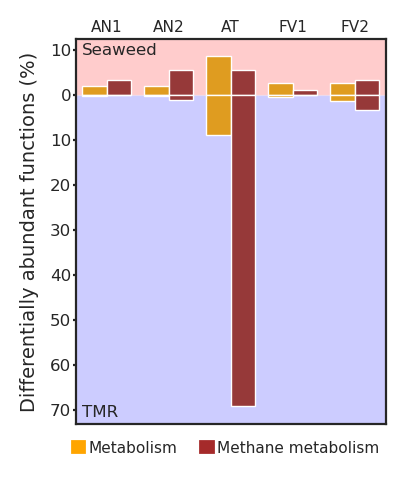

In [3]:
#function to remove "-" from y ticks
def update_ticks(t, pos):
    return str(t).strip('-').split('.')[0]


sign_count = pd.DataFrame() #dataframe to store DAF percentages

cdict = {
    'Metabolism': 'orange',
    'Methane metabolism': 'brown',}
    #'Pathways': 'green'}

#set figure
fig, ax = plt.subplots(1, 1, figsize=(2, 2.5))
   
#get percentage of DAF by treatments 
for ko in KO_TABS:
    maaslin = f'Results/Maaslin2-pooled/{ko}'
    summ = pd.read_csv(f'{maaslin}/significant_results.tsv', sep='\t', index_col=0)
    
    #get table with all functions by stypes
    meta = META.loc[(META.BS.isin(['FL', 'FR']))].copy()
    data = pd.read_csv(f'{TABS}/{ko}_table.tsv', sep='\t', index_col=0) #all functions
    data = data[meta.index].copy()
    data = data.loc[~(data==0).all(axis=1)]

    for trt in CDICT:
        if trt in ['TMR', 'NoT']:
            continue
        j = len(sign_count)
        sign = summ.loc[(summ.value==trt)].copy()
        pos = sign.loc[~sign.coef.astype(str).str.startswith('-')]
        neg = sign.loc[sign.coef.astype(str).str.startswith('-')]
        sign_count.loc[j, 'Function'] = KO_TABS[ko]
        sign_count.loc[j, 'Trt'] = trt
        sign_count.loc[j, 'All_functions'] = len(data.index.unique())
        sign_count.loc[j, 'Sig_functions'] = len(sign.index.unique())
        sign_count.loc[j, 'Sig_%'] = (len(sign.index.unique())/len(data.index.unique()))*100
        sign_count.loc[j, 'Pos_functions'] = len(pos.index.unique())
        sign_count.loc[j, 'Pos_%'] = (len(pos.index.unique())/len(data.index.unique()))*100
        sign_count.loc[j, 'Neg_functions'] = len(neg.index.unique())
        sign_count.loc[j, 'Neg_%'] = (len(neg.index.unique())/len(data.index.unique()))*-100
        
#plot data
df = sign_count.copy()
sns.barplot(data=df, ax=ax, x="Trt", y="Pos_%", hue="Function", palette=cdict, )
sns.barplot(data=df, ax=ax, x="Trt", y="Neg_%", hue="Function", palette=cdict)

#set background color
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax)
ax.axhspan(0, ymax, facecolor='red', alpha=0.2, zorder=0)
ax.axhspan(0, ymin, facecolor='blue', alpha=0.2, zorder=0)

#aesthetics
ax.tick_params(axis='both', labelsize=6, length=1, pad=.5,)
ax.set_xlabel('')
#ax.text(0.5, 1.07, STYPES[st], ha='center', fontsize=7, transform=ax.transAxes)
ax.set_ylabel('Differentially abundant functions (%)', fontsize=7)
plt.setp(ax.patches, linewidth=0.5) #decrease lines around charts
ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks)) #remove "-" from y ticks
ax.text(.02, .96,'Seaweed', size=6, transform=ax.transAxes, ha='left') #annotated upper half
ax.text(.02, .02,'TMR', size=6, transform=ax.transAxes, ha='left') #annotated lower half

#annotate sides
xlabels = [item.get_text() for item in ax.get_xticklabels()]
for pos, lab in enumerate(xlabels):
    xstep = 1/len(xlabels)
    xpos = pos*xstep + xstep/2
    ax.text(xpos, 1.05, lab, size=5.5, ha='center', va='top', transform=ax.transAxes)
ax.set_xticks([])

#legend
ax.get_legend().remove()

#legend
labels = list(cdict.keys())
handles = [mpatches.Patch(color=cdict[l], label=l) for l in labels]

fig.legend(handles, labels, fontsize=5.5, frameon=False, handletextpad=.3, handlelength=.8,
          loc=8, ncol=3, bbox_to_anchor=(0.5, .02), columnspacing=1.5)

sign_count.to_csv('Results/Maaslin2-pooled/Maaslin2_DAF_percentage.tsv', sep='\t')     
plt.savefig('Figures/Maaslin2/Maaslin2_DAF_percentage-pooled.png', bbox_inches='tight', facecolor="w")

### KO Methane metabolism

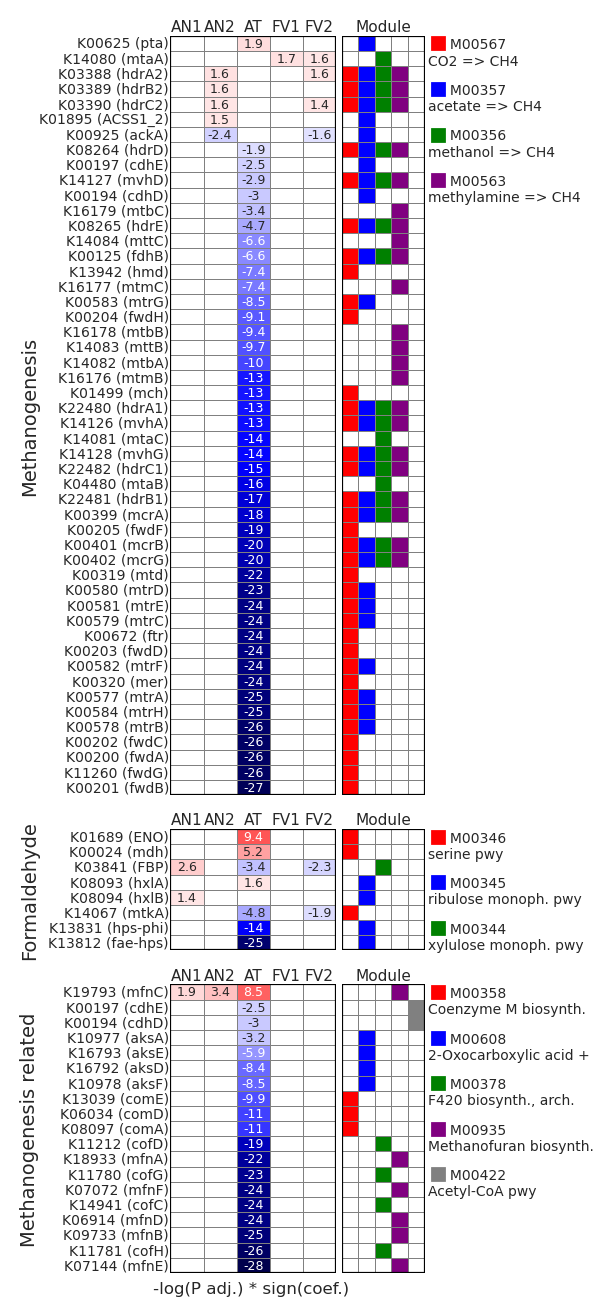

In [4]:
from matplotlib.colors import ListedColormap


def aesthetics(ax, ylen, xlen):
    ax.axhline(y=0, color='k',linewidth=.8)
    ax.axhline(y=ylen, color='k',linewidth=.8)
    ax.axvline(x=0, color='k',linewidth=.8)
    ax.axvline(x=xlen, color='k',linewidth=.8)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(rotation=0, axis='both', labelsize=5, length=0, pad=.5)
    

drep = {
    'methane': 'CH4',
    'pathway': 'pwy',
    'chain extension': '+',
    ': ': '\n',
    'di/tri/': '',
    'thesis': 'th.',
    'phosphate': 'ph.',
    'archaea': 'arch.'}
    
MModTabs = 'Data/Methane_modules'
colors = ['Red', 'Blue', 'Green', 'Purple', 'Grey']
cmap = ListedColormap(colors)

MM = pd.read_csv(f'{MModTabs}/Methane_metabolism_KOs.tsv', sep='\t', index_col=0)
#MM = MM.drop_duplicates(keep=False)
MM['KO_Gene'] = MM.KO +' ('+ MM.Gene + ')'
summ = pd.read_csv(f'Results/Maaslin2-pooled/KO_methane/significant_results.tsv', sep='\t', index_col=0)
MM = MM.loc[MM.KO.isin(summ.index)]
summ['KO_Gene'] = summ.index
for ind in MM.index:
    summ.loc[summ.KO_Gene == MM.loc[ind, 'KO'], 'KO_Gene'] = MM.loc[ind, 'KO_Gene']
summ['hm_value'] = -np.log(summ.qval)*np.sign(summ.coef) #calculate sign. coefficient 
summ = summ.sort_values(by='hm_value', ascending=False, axis=0)
vmax = summ.hm_value.max()
vmin = summ.hm_value.min()

scale = 10
L = len(summ.index.unique())/scale
cats = MM.Category.unique()
sorter = list(CDICT.keys())[1:-1]

#learn lengths of subplots by cats, order of functions and numbers of modules by cat
lengths, iorder, modules = [], [], []
for cat in cats:
    mm = MM.loc[MM.Category==cat].copy()
    lengths.append(len(mm.KO.unique()))
    df = summ.loc[(summ.index.isin(mm.KO))]
    iorder.append(df.KO_Gene.unique())
    modules.append(mm.Module.unique().tolist())
modcolsmax = max([len(m) for m in modules])

#set figure
fig, axes = plt.subplots(len(cats), 3, figsize=(2.3, L + 2*(len(cats[:-1])/L)), 
                sharey='row', gridspec_kw={'width_ratios': [6, 3, 3.5], 'height_ratios': lengths, 
                'wspace': .05, 'hspace': .7/(L + 2*(len(cats[:-1])/L))},)
axs, i = [[r, c] for r in range(len(cats)) for c in range(3)], 0

for j, cat in enumerate(MM.Category.unique()):
    mm = MM.loc[MM.Category == cat].copy()
    df = summ.loc[(summ.index.isin(mm.KO))].copy()
    hdf = df.pivot(index='KO_Gene', columns='value', values='hm_value')
    
    #sort columns
    for col in sorter:
        if col not in hdf.columns:
            hdf[col] = np.nan
    hdf = hdf[sorter]

    #sort rows
    for ind in iorder[j]:
        if ind not in hdf.index:
            hdf.loc[ind, :] = np.nan
    hdf = hdf.reindex(iorder[j])
    
    #plot
    ax, i = axes[axs[i][0]][axs[i][1]], i+1
    sns.heatmap(data=hdf, ax=ax, annot=True, cbar=False, 
                square=False, center=0, cmap='seismic', xticklabels=True, yticklabels=True,
                annot_kws={"size":4.5}, linewidths=.3, linecolor='grey', vmax=vmax, vmin=vmin)
    
    #annotate sides
    xlabels = [item.get_text() for item in ax.get_xticklabels()]
    for pos, lab in enumerate(xlabels):
        ax.text(pos+.5, -1.1, lab, size=5.5, ha='center', va='top', transform=ax.transData)

    #aestheticks
    aesthetics(ax, len(hdf), len(sorter))
    ax.set_ylabel(cat.replace(' assimilation', ''), fontsize=7, labelpad=0)
    
    #add reactions/modules
    hmd = pd.DataFrame()
    for ind in iorder[j]:
        for ci, c in enumerate(modules[j]):
            if len(mm.loc[(mm.KO_Gene==ind) & (mm.Module==c)]) > 0:
                hmd.loc[ind, ci] = ci
            else:
                hmd.loc[ind, ci] = np.nan
    #sort columns
    for col in list(range(modcolsmax)):
        if col not in hmd.columns:
            hmd[col] = np.nan
    hmd = hmd[list(range(modcolsmax))]
    #print(modules[j])
    #display(hmd)
    ax, i = axes[axs[i][0]][axs[i][1]], i+1
    sns.heatmap(data=hmd, cmap=cmap, ax=ax, cbar=False, linewidths=.3, linecolor='grey', 
                xticklabels=True, yticklabels=True, vmax=modcolsmax, vmin=0)
    #aestheticks
    aesthetics(ax, len(hmd), modcolsmax)
    ax.text(modcolsmax/2, -1.1, 'Module', ha='center', va='top', fontsize=5.5, transform=ax.transData)

    #add reactions legend
    ax, i = axes[axs[i][0]][axs[i][1]], i+1
    ax.axis('off')
    ax.set_xlim(0, 1)
    yax, xax = .5, .08
    ystep, xstep = 3, .1
    fsize = 5

    for ri, r in enumerate(modules[j]): #colors             
        sns.scatterplot(x=[xax], y=[yax], marker='s', color=colors[ri], ax=ax, s=30, 
                        clip_on=False, ec='white')
        for k, v in drep.items():
            r = r.replace(k, v)
        ax.text(xax-xstep, yax+1.4, f"     {r}", fontsize=fsize)
        yax += ystep
        
fig.align_labels()
fig.suptitle('-log(P adj.) * sign(coef.)', fontsize=6, y=.105, x=.3)
plt.savefig('Figures/Maaslin2/KO_Methanogenesis-pooled.png', bbox_inches='tight', facecolor='w')